## 5.3.3 Beta distribution and Jacobi Chaos

$$ f(k;\alpha,\beta) = \frac{(1-k)^{\alpha} (1+k)^{\beta}}{2^{\alpha+\beta+1} B(\alpha+1,\beta+1)} = Beta (k, \beta+1, \alpha+1, loc =-1, scale =2)$$

When $\alpha=\beta=0$, $k\sim U(-1,1)$;

When $\alpha =1, \beta =3$, 
$$ f(k; 1, 3) = \frac{(1-k)(1+k)^3}{32 B(2,4)} = \frac{5(1-k)(1+k)^3}{8}$$

[Wiki - Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution)

$$ \zeta \sim Beta (k, \beta+1, \alpha+1, loc =-1, scale =2)$$
[Beta in Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)

When $\alpha = \beta =0$, Jacobi Chaos is [Legendre-chaos](https://en.wikipedia.org/wiki/Legendre_polynomials)

**Legendre Polynomial: ($\alpha = \beta = 0$)**
$$
\begin{align*}
P_0 &= 1\\
P_1 &= x\\
P_2 &= \frac{1}{2}(3x^2 - 1)\\
P_3 &= \frac{1}{2}(5x^3 - 3x)\\
P_4 &= \frac{1}{8}(35x^4 - 30x^2 + 3)\\
\cdots
\end{align*}
$$
Corresponding Hypergeometric orthogonal polynomial
$$ P_n^{(\alpha,\beta)}(x) = \frac{(\alpha+1)_n}{n!}\  _2F_1(-n,n+\alpha+\beta+1;\alpha+1;\frac{1-x}{2})$$

No package for Jacobi chaos in Python

In [58]:
k=0.1

print(beta.pdf(k,4,2,loc=-1,scale=2))

print(5*(1-k)*(1+k)**3/8)

0.7486874999999997
0.7486875000000002


In [8]:
import numpy as np
import numpy.polynomial.legendre as Le   #$\zeta \sim U(-1,1)$, when $\alpha=\beta=0$, Jacobi=Legendre
from math import factorial
from scipy.stats import beta
from scipy.special import gamma  #gamma function
from matplotlib import pyplot as plt
from scipy.integrate import odeint

%matplotlib notebook

In [2]:
def Jacobi(params):
    '''
    The first 4 (degree from 0 to 4) Meixner polynomial
    Follow definition on P642
    '''
    n = params[0]  #degree
    a = params[1]  #parameter alpha value
    b = params[2]  #parameter beta value
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: (a+1) - (a+b+2)*(1-u)/2 
    elif n==2:
        return lambda u: (a+1)*(a+2)/2 - (a+2)*(a+b+3)*(1-u)/2 + (a+b+3)*(a+b+4)*(1-u)**2/8
    elif n==3:
        return lambda u: (a+1)*(a+2)*(a+3)/6 - (a+2)*(a+3)*(a+b+4)*(1-u)/4 + (a+3)*(a+b+4)*(a+b+5)*(1-u)**2/8 - (a+b+4)*(a+b+5)*(a+b+6)*(1-u)**3/48 
    else: #this actually means n=4
        return lambda u: (a+1)*(a+2)*(a+3)*(a+4)/24 - (a+2)*(a+3)*(a+4)*(a+b+5)*(1-u)/12 + (a+3)*(a+4)*(a+b+5)*(a+b+6)*(1-u)**2/16 - (a+4)*(a+b+5)*(a+b+6)*(a+b+7)*(1-u)**3/48 + (a+b+5)*(a+b+6)*(a+b+7)*(a+b+8)*(1-u)**4/384

In [3]:
def f(params):
    c = params[0]
    a = params[1]
    b = params[2]
    if a==1 and b==1:
        return lambda x: x*(a+b+1)
    else:
        return lambda x: x*c    

In [4]:
def Phi(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def inner2_le(params):
    n = params[0]
    a = params[1]  #store the value of alpha from beta distr
    b = params[2]  #store the value of beta from beta distr
    return gamma(n+a+1)*gamma(n+b+1)/((2*n+a+b+1)*gamma(n+a+b+1)*factorial(n))

def product3_le(i,j,l,params):
    #compute \Phi_i*\Phi_j*\Phi_l
    a = params[0]
    b = params[1]
    if a==0 and b==0:
        return lambda x: Le.legval(x, Le.legmul(Le.legmul(Phi(i),Phi(j)),Phi(l))) 
    else: #actually this means a=1, b=3
        return lambda x: Jacobi([i]+params)(x)*Jacobi([j]+params)(x)*Jacobi([l]+params)(x)

def inner3_le(P,i,j,l,params):
    #compute <\Phi_i\Phi_j\Phi_l>
    a = params[0]
    b = params[1]
    if a==0 and b==0:
        #Set up Gauss-Legendre quadrature, weighting function is 1
        m=(P+1)**2
        x, w=Le.leggauss(m)        #x is point, w is the corresponding weight
        inner=sum([product3_le(i,j,l,params)(x[idx]) * w[idx] for idx in range(m)])
        return inner/2       ##because of the weight
    else:
        nsample = 1000
        rv = beta.rvs(b+1, a+1, loc=-1, scale=2, size=nsample, random_state=None)
        inner = np.mean(product3_le(i,j,l,params)(rv))*gamma(a+1)*gamma(b+1)/gamma(a+b+2)   
        return inner


In [5]:
def ode_system_le(y, t, P, params):   
    #P indicates the highest degree
    a = params[0]
    b = params[1]
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_le(P,i,j,l,params)*ki_le[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_le((l,a,b))
    return dydt

In [6]:
#h = unif_icdf([-1,1])                          #index k follows uniform distr
P = 4
params = [0, 0]
ki_le = [0,1]+[0]*(P-1)
sol_le = odeint(ode_system_le, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, params)) 

<IPython.core.display.Javascript object>


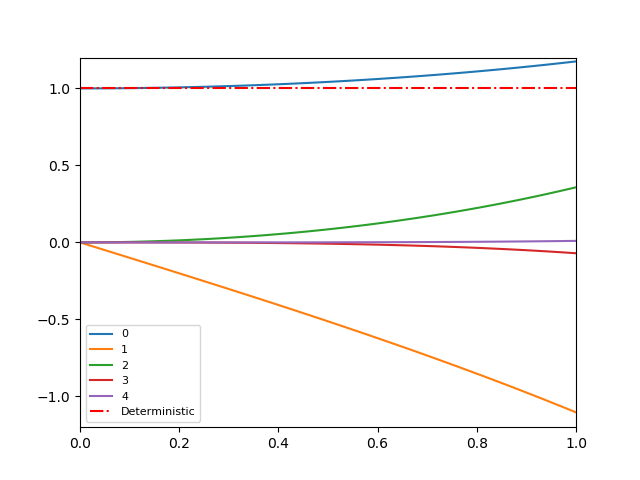

In [9]:
plt.figure()
plt.ylim([-1.2,1.2])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_le[:,i],label=i)

plt.axhline(y=1.0, color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

### Error plot when $\alpha=\beta=0$

$$
\bar{y}_{exact}(t) = \frac{\hat{y_0}}{2t}(e^{t} - e^{-t}) \ \ \ \ \ \ \ \ \bar{y}(t) = y_0
$$
So 
$$
\epsilon_{mean}(t) = \left| \frac{\bar{y}(t) - \bar{y}_{exact}(t)}{\bar{y}_{exact}(t)}\right|
$$

$$
\sigma_{exact}(t) = \frac{1-e^{-2}}{2} \ \ \ \ \ \ \ \ \sigma(t) = a_1y_1^2 +a_2y_2^2+a_3y_3^2+a_4y_4^2
$$
The coefficients $(a_1, a_2, a_3, a_4)$ in $\sigma(t)$ can be obtained by code below.

So
$$
\epsilon_{variance}(t) = \left| \frac{\sigma(t) - \sigma_{exact}(t)}{\sigma_{exact}(t)} \right|= \ldots
$$

<font color = red>This is $\alpha=\beta=0$
$\downarrow$

In [10]:
allcoeff_533_0 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_533_0[1,:]=np.ones(4)
y_533_0 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

params = [0, 0]

for i in range(4):
    P=i+1
    ki_le = allcoeff_533_0[:,i]
    y_mid=odeint(ode_system_le, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, params))[1,:]
    y_533_0[:,i] = y_mid.tolist()+[0]*(4-P)

In [10]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(beta.expect(Jacobi((i,0,0)), args=(1,1), loc=-1, scale=2, lb=None, ub=None, conditional=False))

1.0
-3.51635587001176e-18
9.020562075079397e-17
3.2082226403008723e-16
-2.5326962749261384e-16
-2.5326962749261384e-16
-2.5326962749261384e-16
-2.5326962749261384e-16
-2.5326962749261384e-16


In [11]:
def g(params):
    n = params
    return lambda u: (Jacobi((n,0,0))(u))**2

for i in range(1,5):
    print(beta.expect(g(i), args=(1, 1), loc=-1, scale=2, lb=None, ub=None, conditional=False))

0.3333333333333333
0.2
0.1428571428571429
0.11111111111111023


In [12]:
############# alpha = beta = 0  ################ 
mean_533_0 = y_533_0[0,:]
mean_exact_533_0 = 1/2*(np.e - np.e**(-1))
error_mean_533_0 = np.abs((mean_533_0 - mean_exact_533_0)/mean_exact_533_0)


sigma2_533_0=np.zeros(4)
for i in range(4):
    sigma2_533_0[i]=1/3*y_533_0[1,i]**2+1/5*y_533_0[2,i]**2+1/7*y_533_0[3,i]**2+1/9*y_533_0[4,i]**2
    
sigma2_exact_533_0 = 1/2-1/2*np.e**(-2)
error_var_533_0 = np.abs((sigma2_533_0-sigma2_exact_533_0)/sigma2_exact_533_0)

### Error plot when $\alpha=1,\beta=3$

$$
\bar{y}_{exact}(t) = \frac{5\hat{y_0}}{8}(-12e + 612 e^{-1}) \ \ \ \ \ \ \ \ \bar{y}(t) = y_0
$$
So 
$$
\epsilon_{mean}(t) = \left| \frac{\bar{y}(t) - \bar{y}_{exact}(t)}{\bar{y}_{exact}(t)}\right|
$$

$$
\sigma_{exact}(t) = 5\hat{y_0}^2e^{-2} - \frac{25}{64}\hat{y_0}^2(-12e+612e^{-1})^2 \ \ \ \ \ \ \ \ \sigma(t) = a_1y_1^2 +a_2y_2^2+a_3y_3^2+a_4y_4^2
$$
The coefficients $(a_1, a_2, a_3, a_4)$ in $\sigma(t)$ can be obtained by code below.

So
$$
\epsilon_{variance}(t) = \left| \frac{\sigma(t) - \sigma_{exact}(t)}{\sigma_{exact}(t)} \right|= \ldots
$$

<font color = red>This is $\alpha=1,\beta=3$
$\downarrow$

In [13]:
allcoeff_533_1 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_533_1[0,:]=1/3*np.ones(4)
allcoeff_533_1[1,:]=1/3*np.ones(4)
y_533_1 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

params = [1, 3]

for i in range(4):
    P=i+1
    ki_le = allcoeff_533_1[:,i]
    y_mid=odeint(ode_system_le, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, params))[1,:]
    y_533_1[:,i] = y_mid.tolist()+[0]*(4-P)

/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [14]:
y_533_1

array([[ 9.67971666e-01,  9.99234457e-01,  9.99976844e-01,
         9.88201315e-01],
       [-3.18275458e-02, -7.32690220e-04, -4.60583490e-05,
        -1.23452722e-02],
       [ 0.00000000e+00, -6.54370491e-05,  4.58728490e-06,
         5.52619983e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.03499325e-05,
         1.90219706e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.54801662e-04]])

`beta.expect(func, args=(a, b), loc=0, scale=1, lb=None, ub=None, conditional=False, **kwds)`

In [121]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(beta.expect(Jacobi((i,1,3)), args=(4,2), loc=-1, scale=2, lb=None, ub=None, conditional=False))

0.9999999999999999
5.551115123125783e-17
2.7755575615628914e-17
3.7643499428696714e-16
-9.228728892196614e-16
-9.228728892196614e-16
-9.228728892196614e-16
-9.228728892196614e-16
-9.228728892196614e-16


In [122]:
def g(params):
    n = params
    return lambda u: (Jacobi((n,1,3))(u))**2

for i in range(1,5):
    print(beta.expect(g(i), args=(4, 2), loc=-1, scale=2, lb=None, ub=None, conditional=False))

1.1428571428571426
1.111111111111111
1.0389610389610364
0.9615384615384587


In [15]:
############# alpha = 1, beta = 3  ################ 

mean_533_1 = y_533_1[0,:]
mean_exact_533_1 = 5/8*(-12*np.e +612*np.e**(-1))
error_mean_533_1 = np.abs((mean_533_1 - mean_exact_533_1)/mean_exact_533_1)


sigma2_533_1=np.zeros(4)
for i in range(4):
    sigma2_533_1[i]=8/7*y_533_1[1,i]**2+10/9*y_533_1[2,i]**2+1.0389610389610364*y_533_1[3,i]**2+0.9615384615384587*y_533_1[4,i]**2
    
sigma2_exact_533_1 = 5*np.e**(-2) -25/64*(-12*np.e +612*np.e**(-1))**2
error_var_533_1 = np.abs((sigma2_533_1-sigma2_exact_533_1)/sigma2_exact_533_1)

In [116]:
print(mean_533_1)
print(mean_exact_533_1)
print(error_mean_533_1)
print(error_var_533_1)

[0.90656886 0.9902277  0.99044444 0.98238702]
120.32677253463385
[0.99246578 0.99177051 0.99176871 0.99183567]
[1.0000008  1.00000001 1.00000001 1.00000002]


### <font color = red> The error of mean plots when $\alpha=\beta=0$ is a little different since it is close to machine epsilon??, I am using lengendre package in python since $\alpha=\beta=0$.
    
### <font color = red> But when $\alpha=1, \beta=3$, the error plots are so strange, I am using the lengendre functions I defined by myself

<IPython.core.display.Javascript object>


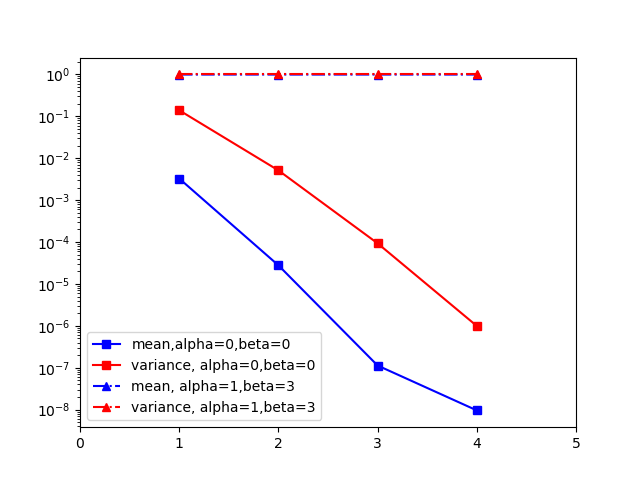

In [16]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_533_0,'-bs',label='mean,alpha=0,beta=0')
plt.semilogy([1,2,3,4],error_var_533_0,'-rs',label='variance, alpha=0,beta=0') 
plt.semilogy([1,2,3,4],error_mean_533_1,'-.b^',label='mean, alpha=1,beta=3')
plt.semilogy([1,2,3,4],error_var_533_1,'-.r^',label='variance, alpha=1,beta=3')  
plt.legend()